# Fully Connected Experiments


## 1. Setup

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns

from copy import deepcopy
from IPython import display
from random import uniform
from semitorch import (
    ClampAdamW, ClampSGD,
    Lukasiewicz, lukasiewicz_parameters,
    Viterbi, viterbi_parameters,
    IrisDatasetTransformer, HeartDiseaseDatasetTransformer,
    CirclesDatasetTransformer, RingsDatasetTransformer,
    SpheresDatasetTransformer,
)
from statistics import quantiles
from torch.utils.data import DataLoader
from tqdm.notebook import trange

data_path = os.path.abspath("./data" if os.path.isdir("./data") else "../../data")
device = "cuda" if torch.cuda.is_available() else "cpu"


def split_dataset(dataset: torch.utils.data.Dataset):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    return torch.utils.data.random_split(dataset, [train_size, test_size])

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.7
[Taichi] Starting on arch=cuda


### Load iris data
[https://www.kaggle.com/datasets/uciml/iris](https://www.kaggle.com/datasets/uciml/iris)

In [2]:
iris_df = pd.read_csv(
    os.path.join(data_path, "iris.csv"), index_col=0, dtype={"Species": "string"}
)
iris_x = torch.Tensor(iris_df.iloc[:, [0, 1, 2, 3]].to_numpy())
iris_x = IrisDatasetTransformer(data_to_transform=iris_x, device=device).transform()

iris_y = (
    iris_df["Species"]
    .map({
        "Iris-setosa": 0,
        "Iris-versicolor": 1,
        "Iris-virginica": 2,
    }).to_numpy()
)
iris_y = torch.Tensor(iris_y).to(torch.int64).to(device)
print(f"Iris dataset: input features = {iris_x.shape[1]}, "
      f"classes = {torch.unique(iris_y).shape[0]}, "
      f"samples = {len(iris_y)}")

iris_train, iris_test = split_dataset(torch.utils.data.TensorDataset(iris_x, iris_y))

iris_train_loader = DataLoader(iris_train, batch_size=8, shuffle=True)
iris_test_loader = DataLoader(iris_test, batch_size=len(iris_test), shuffle=False)

Iris dataset: input features = 4, classes = 3, samples = 150


### Load heart disease data

[https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset)

In [3]:
heart_df = pd.read_csv(os.path.join(data_path, "heart.csv"))
heart_x = torch.Tensor(heart_df.iloc[:, range(13)].to_numpy()).to(torch.float32)
heart_x = HeartDiseaseDatasetTransformer(data_to_transform=heart_x, device=device).transform()
heart_y = torch.Tensor(heart_df.iloc[:, -1].to_numpy()).to(torch.int64).to(device)

print(f"Heart disease dataset: input features = {heart_x.shape[1]}, "
      f"classes = {torch.unique(heart_y).shape[0]}, "
      f"samples = {len(heart_y)}")

heart_train, heart_test = split_dataset(torch.utils.data.TensorDataset(heart_x, heart_y))
heart_train_loader = DataLoader(heart_train, batch_size=32, shuffle=True)
heart_test_loader = DataLoader(heart_test, batch_size=len(heart_test))

Heart disease dataset: input features = 30, classes = 2, samples = 303


### Load Naitzat data

[https://github.com/topnn/topnn_framework](https://github.com/topnn/topnn_framework)

In [4]:
circles_x, circles_y = torch.load(os.path.join(data_path, "naitzat", "circles_type_8.pt"))
circles_x = CirclesDatasetTransformer(data_to_transform=circles_x, device=device).transform()
circles_y = torch.squeeze(circles_y)
print(f"Circles dataset: input features = {circles_x.shape[1]}, "
      f"classes = {torch.unique(circles_y).shape[0]}, "
      f"samples = {len(circles_y)}")
circles_train, circles_test = split_dataset(torch.utils.data.TensorDataset(circles_x, circles_y))
circles_train_loader = DataLoader(circles_train, batch_size=16, shuffle=True)
circles_test_loader = DataLoader(circles_test, batch_size=len(circles_test), shuffle=True)

rings_x, rings_y = torch.load(os.path.join(data_path, "naitzat", "rings_9.pt"))
rings_x = RingsDatasetTransformer(data_to_transform=rings_x, device=device).transform()
rings_y = torch.squeeze(rings_y)
print(f"Rings dataset: input features = {rings_x.shape[1]}, "
      f"classes = {torch.unique(rings_y).shape[0]}, "
      f"samples = {len(rings_y)}")
rings_train, rings_test = split_dataset(torch.utils.data.TensorDataset(rings_x, rings_y))
rings_train_loader = DataLoader(rings_train, batch_size=16, shuffle=True)
rings_test_loader = DataLoader(rings_test, batch_size=len(rings_test), shuffle=True)

spheres_x, spheres_y = torch.load(os.path.join(data_path, "naitzat", "spheres_9.pt"))
spheres_x = SpheresDatasetTransformer(data_to_transform=spheres_x, device=device).transform()
spheres_y = torch.squeeze(spheres_y)
print(f"Spheres dataset: input features = {spheres_x.shape[1]}, "
      f"classes = {torch.unique(spheres_y).shape[0]}, "
      f"samples = {len(spheres_y)}")
spheres_train, spheres_test = split_dataset(torch.utils.data.TensorDataset(spheres_x, spheres_y))
spheres_train_loader = DataLoader(spheres_train, batch_size=16, shuffle=True)
spheres_test_loader = DataLoader(spheres_test, batch_size=len(spheres_test), shuffle=True)

Circles dataset: input features = 2, classes = 2, samples = 15950
Rings dataset: input features = 3, classes = 2, samples = 45000
Spheres dataset: input features = 3, classes = 2, samples = 37800


## 2. Models

In [5]:
class IrisModel(nn.Module):
    def __init__(self, reverse: bool = False) -> None:
        super().__init__()
        self.name = "iris"

        if not reverse:
            self.layer1 = Viterbi(4, 16)
            self.layer2 = Lukasiewicz(16, 16)
            self.head = Viterbi(16, 3, bias=False)
        else:
            self.layer1 = Lukasiewicz(4, 16)
            self.layer2 = Viterbi(16, 16)
            self.head = Lukasiewicz(16, 3, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result_1 = self.layer1(x)
        result_2 = self.layer2(result_1)

        return self.head(result_2)

In [6]:
class HeartModel(nn.Module):
    def __init__(self, reverse: bool = False) -> None:
        super().__init__()
        self.name = "heart"

        if not reverse:
            self.layer1 = Viterbi(30, 16)
            self.layer2 = Lukasiewicz(16, 16)
            self.layer3 = Viterbi(16, 16)
            self.layer4 = Lukasiewicz(16, 16)
            self.head = Viterbi(16, 2, bias=False)
        else:
            self.layer1 = Lukasiewicz(30, 16)
            self.layer2 = Viterbi(16, 16)
            self.layer3 = Lukasiewicz(16, 16)
            self.layer4 = Viterbi(16, 16)
            self.head = Lukasiewicz(16, 2, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result_1 = self.layer1(x)
        result_2 = self.layer2(result_1)
        result_3 = self.layer3(result_2)
        result_4 = self.layer4(result_3)

        return self.head(result_4)

In [7]:
class CirclesModel(nn.Module):
    def __init__(self, reverse: bool = False) -> None:
        super().__init__()
        self.name = "circles"

        if not reverse:
            self.layer1 = Viterbi(2, 8)
            self.layer2 = Lukasiewicz(8, 8)
            self.layer3 = Viterbi(8, 8)
            self.layer4 = Lukasiewicz(8, 8)
            self.head = Viterbi(8, 2, bias=False)
        else:
            self.layer1 = Lukasiewicz(2, 8)
            self.layer2 = Viterbi(8, 8)
            self.layer3 = Lukasiewicz(8, 8)
            self.layer4 = Viterbi(8, 8)
            self.head = Lukasiewicz(8, 2, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result_1 = self.layer1(x)
        result_2 = self.layer2(result_1)
        result_3 = self.layer3(result_2)
        result_4 = self.layer4(result_3)

        return self.head(result_4)

In [8]:
class RingsModel(nn.Module):
    def __init__(self, reverse: bool = False) -> None:
        super().__init__()
        self.name = "rings"

        if not reverse:
            self.layer1 = Viterbi(3, 8)
            self.layer2 = Lukasiewicz(8, 8)
            self.layer3 = Viterbi(8, 8)
            self.layer4 = Lukasiewicz(8, 8)
            self.head = Viterbi(8, 2, bias=False)
        else:
            self.layer1 = Lukasiewicz(3, 8)
            self.layer2 = Viterbi(8, 8)
            self.layer3 = Lukasiewicz(8, 8)
            self.layer4 = Viterbi(8, 8)
            self.head = Lukasiewicz(8, 2, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result_1 = self.layer1(x)
        result_2 = self.layer2(result_1)
        result_3 = self.layer3(result_2)
        result_4 = self.layer4(result_3)

        return self.head(result_4)

In [9]:
class SpheresModel(nn.Module):
    def __init__(self, reverse: bool = False) -> None:
        super().__init__()
        self.name = "spheres"

        if not reverse:
            self.layer1 = Viterbi(3, 8)
            self.layer2 = Lukasiewicz(8, 8)
            self.layer3 = Viterbi(8, 8)
            self.layer4 = Lukasiewicz(8, 8)
            self.head = Viterbi(8, 2, bias=False)
        else:
            self.layer1 = Lukasiewicz(3, 8)
            self.layer2 = Viterbi(8, 8)
            self.layer3 = Lukasiewicz(8, 8)
            self.layer4 = Viterbi(8, 8)
            self.head = Lukasiewicz(8, 2, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result_1 = self.layer1(x)
        result_2 = self.layer2(result_1)
        result_3 = self.layer3(result_2)
        result_4 = self.layer4(result_3)

        return self.head(result_4)

In [10]:
def count_parameters(parameters) -> int:
    return sum(p.numel() for p in parameters if p.requires_grad)

## 3. Training

In [11]:
def accuracy(model: nn.Module, x: torch.Tensor, y: torch.Tensor) -> float:
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)

        return (y.cpu() == prediction).sum().item() / float(y.numel())


def test(model: nn.Module, testloader: DataLoader) -> float:
    model.eval()
    accs = []

    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))

    return sum(accs) / len(accs)


def confusion_matrix(model: nn.Module, testloader: DataLoader) -> None:
    model.eval()

    output_classes = get_features_classes_of(model.name)

    conf_matrix = torch.zeros(len(output_classes), len(output_classes))

    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)

            for i in range(len(y)):
                conf_matrix[y[i], prediction[i]] += 1

    plt.figure(figsize=(6, 4))

    df_cm = pd.DataFrame(conf_matrix, index=output_classes, columns=output_classes).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def get_features_classes_of(name: str) -> list[str]:
    if name == "iris":
        output_classes = [f"{i}" for i in range(3)]
    elif name == "heart":
        output_classes = [f"{i}" for i in range(2)]
    elif name == "circles":
        output_classes = [f"{i}" for i in range(2)]
    elif name == "rings":
        output_classes = [f"{i}" for i in range(2)]
    elif name == "spheres":
        output_classes = [f"{i}" for i in range(2)]
    else:
        raise Exception(f"Unknown model name {name}")

    return output_classes


def train(
        model: nn.Module,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizers: list[torch.optim.Optimizer],
        schedulers: list[torch.optim.lr_scheduler],
        loss: torch.nn.modules.loss,
        epochs: int,
        statistics_mode: bool = False  # If True: (return max acc and do not generate output)
) -> None | float:
    accs = []  # list of accuracy on the test dataset for every epoch
    trainaccs = []  # a list of the accuracies of all the training batches

    if not statistics_mode:
        fig, ax = plt.subplots(1, 1, figsize=[6, 4])
        hdisplay = display.display("", display_id=True)

    for _ in trange(epochs):
        model.train()

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            for optimizer in optimizers:
                optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu() == prediction).sum().item() / float(y.numel()))

            l = loss(yout, y.squeeze())
            l.backward()
            for optimizer in optimizers:
                optimizer.step()

            for scheduler in schedulers:
                scheduler.step()

        accs.append(test(model, testloader))

        if not statistics_mode:
            ax.clear()
            ax.set_xlim(0, epochs)
            ax.set_ylim(-0.02, 1.02)
            ax.plot(
                np.linspace(0, len(accs), len(trainaccs)),
                trainaccs,
                ".",
                markersize=1.5,
                markerfacecolor=(0, 0, 1, 0.3),
            )
            ax.plot(np.linspace(1, len(accs), len(accs)), accs)
            ax.text(
                0.6 * epochs,
                0.30,
                f"max test acc = {max(accs):.2%}",
                ha="center",
                fontsize=10,
            )
            hdisplay.update(fig)

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    if not statistics_mode:
        confusion_matrix(model, testloader)

    if statistics_mode:
        return max(accs)

In [12]:
def run_model_for_config(config: dict, best_accuracy: float) -> dict:
    loss = nn.CrossEntropyLoss()
    epochs = 20

    # Create model and set data loaders
    dataset = config["dataset"]
    if dataset == "iris":
        model = IrisModel(reverse=config["reverse"]).to(device)
        trainloader = iris_train_loader
        testloader = iris_test_loader
    elif dataset == "heart":
        model = HeartModel(reverse=config["reverse"]).to(device)
        trainloader = heart_train_loader
        testloader = heart_test_loader
    elif dataset == "circles":
        model = CirclesModel(reverse=config["reverse"]).to(device)
        trainloader = circles_train_loader
        testloader = circles_test_loader
    elif dataset == "rings":
        model = RingsModel(reverse=config["reverse"]).to(device)
        trainloader = rings_train_loader
        testloader = rings_test_loader
    elif dataset == "spheres":
        model = SpheresModel(reverse=config["reverse"]).to(device)
        trainloader = spheres_train_loader
        testloader = spheres_test_loader
    else:
        raise Exception(f"Unknown dataset: {dataset}")

    # Separate model parameters
    viterbi_params = viterbi_parameters(model)
    lukasiewicz_params = lukasiewicz_parameters(model)

    # Create viterbi optimizer
    viterbi_lr = config["viterbi_lr"]
    # if config["viterbi_optimiser"] == "AdamW":
    #     viterbi_optimiser = ClampAdamW(viterbi_params, lr=viterbi_lr)
    # elif config["viterbi_optimiser"] == "SGD":
    #     viterbi_optimiser = ClampSGD(viterbi_params, lr=viterbi_lr)
    # else:
    #     raise Exception(f"Unknown optimiser: {config['viterbi_optimiser']}")
    # if config["viterbi_scheduler"]:
    #     viterbi_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #         viterbi_optimiser,
    #         max_lr=viterbi_lr,
    #         anneal_strategy="linear",
    #         pct_start=0.3,
    #         three_phase=True,
    #         final_div_factor=1000.0,
    #         div_factor=10.0,
    #         steps_per_epoch=len(trainloader),
    #         epochs=epochs,
    #     )
    # else:
    #     viterbi_scheduler = None
    viterbi_optimiser = ClampAdamW(viterbi_params, lr=viterbi_lr)
    viterbi_scheduler = None

    # Create lukasiewicz optimizer
    lukasiewicz_lr = config["viterbi_lr"]
    # if config["lukasiewicz_optimiser"] == "AdamW":
    #     lukasiewicz_optimiser = ClampAdamW(lukasiewicz_params, lr=lukasiewicz_lr)
    # elif config["lukasiewicz_optimiser"] == "SGD":
    #     lukasiewicz_optimiser = ClampSGD(lukasiewicz_params, lr=lukasiewicz_lr)
    # else:
    #     raise Exception(f"Unknown optimiser: {config['lukasiewicz_optimiser']}")
    # if config["lukasiewicz_scheduler"]:
    #     lukasiewicz_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #         lukasiewicz_optimiser,
    #         max_lr=lukasiewicz_lr,
    #         anneal_strategy="linear",
    #         pct_start=0.3,
    #         three_phase=True,
    #         final_div_factor=1000.0,
    #         div_factor=10.0,
    #         steps_per_epoch=len(trainloader),
    #         epochs=epochs,
    #     )
    # else:
    #     lukasiewicz_scheduler = None
    lukasiewicz_optimiser = ClampAdamW(lukasiewicz_params, lr=lukasiewicz_lr)
    lukasiewicz_scheduler = None

    # Create optimizers and schedulers
    optimizers = list(filter(lambda opt: opt is not None, [viterbi_optimiser, lukasiewicz_optimiser]))
    schedulers = list(filter(lambda sch: sch is not None, [viterbi_scheduler, lukasiewicz_scheduler]))

    reported_accuracy, last_reported_accuracy = [], []
    for epoch in range(epochs):
        last_reported_accuracy = reported_accuracy

        # Feed to training function
        reported_accuracy = train_model(
            model,
            trainloader,
            testloader,
            optimizers,
            schedulers,
            loss,
        )

        # Try some stopping conditions
        if (((epoch > 2) and (reported_accuracy < 0.15))
                or ((epoch > 5) and (reported_accuracy < best_accuracy / 2))
                or ((epoch > 2) and (abs(last_reported_accuracy - reported_accuracy) < 1e-6))):
            # Run is done, no sense to train it any further
            # or bad trial
            break  # Break for-loop to report

    return {"accuracy": reported_accuracy, "config": config}


def train_model(
        model: nn.Module,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizers: list[torch.optim.Optimizer],
        schedulers: list[torch.optim.lr_scheduler],
        loss: torch.nn.modules.loss,
) -> float:
    model.train()

    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        for optimizer in optimizers:
            optimizer.zero_grad()

        l = loss(model(x), y.squeeze())
        l.backward()

        for optimizer in optimizers:
            optimizer.step()

        for scheduler in schedulers:
            scheduler.step()

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    return test(model, testloader)


def run_random_search_for_config(config: dict) -> dict:
    best_accuracy, best_config, current_config = 0, deepcopy(config), deepcopy(config)
    step_size, bad_step_counter, good_step_counter = 0.1, 0, 0
    for num_trial in range(100):
        result = run_model_for_config(current_config, best_accuracy=best_accuracy)

        if result["accuracy"] > best_accuracy:
            bad_step_counter = 0
            good_step_counter += 1

            best_accuracy, best_config = result["accuracy"], deepcopy(current_config)
        else:
            bad_step_counter += 1
            good_step_counter = 0

        if bad_step_counter > 10:
            break  # Terminate run, likely no better accuracy possible

        current_config, step_size, bad_step_counter, good_step_counter = adaptive_step_update_config(
            config=deepcopy(best_config),
            step_size=step_size,
            bad_step_counter=bad_step_counter,
            good_step_counter=good_step_counter,
        )

        if step_size < 1e-2:
            # Step size too small to make any impact, terminate run
            break

    return {"accuracy": best_accuracy, "config": best_config}


def adaptive_step_update_config(
        config: dict,
        step_size: float,
        bad_step_counter: int,
        good_step_counter: int,
) -> tuple[dict, float, int, int]:
    # Update step_size
    if bad_step_counter > 2:
        step_size /= 2
        bad_step_counter = 0
    if (good_step_counter > 2) and (step_size < 0.5):
        step_size *= 2
        good_step_counter = 0

    # Update config values
    config["viterbi_lr"] = uniform(
        config["viterbi_lr"] * (1 - step_size),
        config["viterbi_lr"] * (1 + step_size),
    )
    config["lukasiewicz_lr"] = uniform(
        config["lukasiewicz_lr"] * (1 - step_size),
        config["lukasiewicz_lr"] * (1 + step_size),
    )

    return config, step_size, bad_step_counter, good_step_counter


def find_best_model_for(config: dict) -> None:
    # current_config, results = deepcopy(config), []

    # for viterbi_optimiser in ["AdamW", "SGD"]:
    #     current_config["viterbi_optimiser"] = viterbi_optimiser
    #     for viterbi_scheduler in [True, False]:
    #         current_config["viterbi_scheduler"] = viterbi_scheduler
    #         for lukasiewicz_optimiser in ["AdamW", "SGD"]:
    #             current_config["lukasiewicz_optimiser"] = lukasiewicz_optimiser
    #             for lukasiewicz_scheduler in [True, False]:
    #                 current_config["lukasiewicz_scheduler"] = lukasiewicz_scheduler
    # 
    #                 result, counter = {"accuracy": 0, "config": {}}, 0
    #                 while counter < 5:
    #                     current_config = create_random_config_for_model(deepcopy(current_config))
    #                     print(f"Starting semiring run for config {current_config}")
    #                     subresult = run_random_search_for_config(current_config)
    #                     if subresult["accuracy"] > result["accuracy"]:
    #                         result = subresult
    #                     counter += 1
    # 
    #                 display.clear_output(wait=True)
    #                 results.append(result)
    

    # sorted_results = sorted(results, key=lambda dictionary: dictionary["accuracy"], reverse=True)

    # display.clear_output(wait=True)
    # print(f'Best trial config with accuracy of {sorted_results[0]["accuracy"]}: {sorted_results[0]["config"]}')
    # print(f"-----------------")
    # print(*sorted_results, sep="\n")
    
    result = {"accuracy": 0, "config": {}}
    while result["accuracy"] < 0.5:
        current_config = create_random_config_for_model(deepcopy(config))

        print(f"Starting run for config {current_config}")
        result = run_random_search_for_config(current_config)
        result2 = run_model_for_config(current_config, result["accuracy"])
        if abs(result["accuracy"] - result2["accuracy"]) > 0.2:
            result["accuracy"] = 0
        print(f"Accuracy = {result['accuracy']}")

    display.clear_output(wait=True)
    print(result)


def create_random_config_for_model(config: dict) -> dict:
    config["viterbi_lr"] = 10 ** uniform(-3, -1)
    config["lukasiewicz_lr"] = 10 ** uniform(-3, -1)

    return config

# Experiments

# Iris

In [13]:
find_best_model_for(config={
    "dataset": "iris",
    "reverse": False,
})

Best trial config with accuracy of 0.5666666666666667: {'dataset': 'iris', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': True, 'viterbi_lr': 0.013297377295240047, 'lukasiewicz_lr': 0.01086887540342563}
-----------------
{'accuracy': 0.5666666666666667, 'config': {'dataset': 'iris', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': True, 'viterbi_lr': 0.013297377295240047, 'lukasiewicz_lr': 0.01086887540342563}}
{'accuracy': 0.5666666666666667, 'config': {'dataset': 'iris', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': False, 'viterbi_lr': 0.017145480470434057, 'lukasiewicz_lr': 0.004983323107451874}}
{'accuracy': 0.5666666666666667, 'config': {'dataset': 'iris', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': 

In [14]:
find_best_model_for(config={
    "dataset": "iris",
    "reverse": True,
})

Best trial config with accuracy of 0.5666666666666667: {'dataset': 'iris', 'reverse': True, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': True, 'viterbi_lr': 0.0060436198329632965, 'lukasiewicz_lr': 0.0850385320576317}
-----------------
{'accuracy': 0.5666666666666667, 'config': {'dataset': 'iris', 'reverse': True, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': True, 'viterbi_lr': 0.0060436198329632965, 'lukasiewicz_lr': 0.0850385320576317}}
{'accuracy': 0.5666666666666667, 'config': {'dataset': 'iris', 'reverse': True, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': False, 'viterbi_lr': 0.07100179268991495, 'lukasiewicz_lr': 0.0033353434517794708}}
{'accuracy': 0.5666666666666667, 'config': {'dataset': 'iris', 'reverse': True, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True

Model has 400 trainable parameters, of which 128 are Viterbi and 272 are Lukasiewicz related


''

  0%|          | 0/20 [00:00<?, ?it/s]

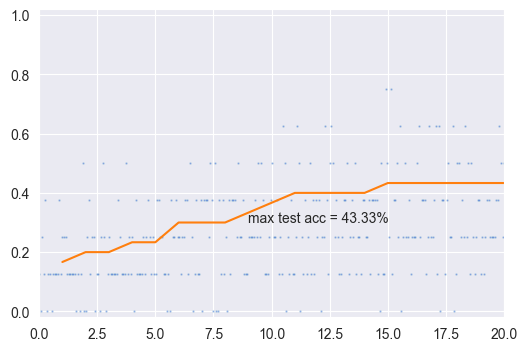

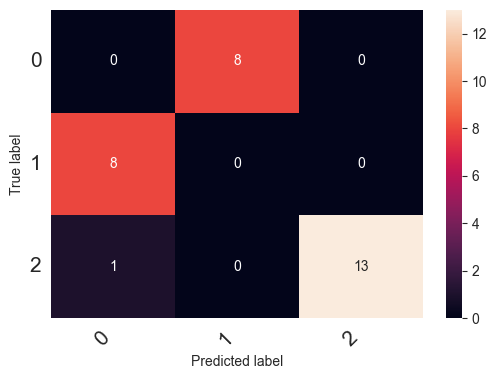

In [30]:
model = IrisModel(reverse=False).to(device)
print(f"Model has {count_parameters(model.parameters())} trainable parameters, "
      f"of which {count_parameters(viterbi_parameters(model))} are Viterbi "
      f"and {count_parameters(lukasiewicz_parameters(model))} are Lukasiewicz related")

viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.009970981326610727)
lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.0017231455097293821)

train(
    model,
    iris_train_loader,
    iris_test_loader,
    [viterbi_optimiser, lukasiewicz_optimiser],
    [],
    nn.CrossEntropyLoss(),
    20,
)

Model has 400 trainable parameters, of which 272 are Viterbi and 128 are Lukasiewicz related


''

  0%|          | 0/20 [00:00<?, ?it/s]

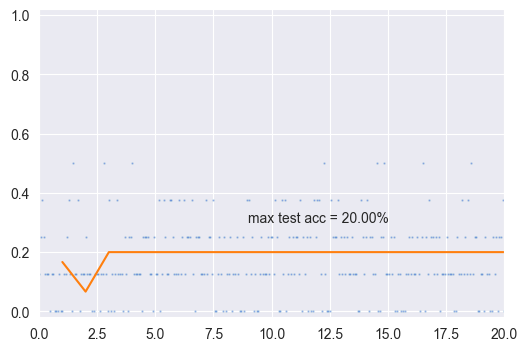

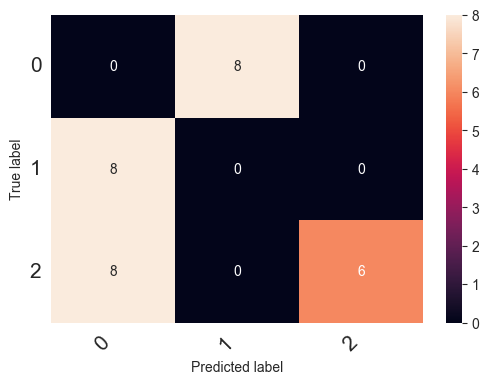

In [32]:
model = IrisModel(reverse=True).to(device)
print(f"Model has {count_parameters(model.parameters())} trainable parameters, "
      f"of which {count_parameters(viterbi_parameters(model))} are Viterbi "
      f"and {count_parameters(lukasiewicz_parameters(model))} are Lukasiewicz related")

viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.006665436335842091)
lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.009143360417009956)

train(
    model,
    iris_train_loader,
    iris_test_loader,
    [viterbi_optimiser, lukasiewicz_optimiser],
    [],
    nn.CrossEntropyLoss(),
    20,
)

In [31]:
accs = []

for i in range(100):
    print(i)
    
    model = IrisModel(reverse=False).to(device)
    
    viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.009970981326610727)
    lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.0017231455097293821)
    
    accs.append(train(
        model,
        iris_train_loader,
        iris_test_loader,
        [viterbi_optimiser, lukasiewicz_optimiser],
        [],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(accs))
print(quantiles(accs))
print(max(accs))

0.43333333333333335
[0.43333333333333335, 0.43333333333333335, 0.43333333333333335]
0.4666666666666667


In [13]:
accs = []

for i in range(100):
    print(i)
    
    model = IrisModel(reverse=True).to(device)
    
    viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.006665436335842091)
    lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.009143360417009956)
    
    accs.append(train(
        model,
        iris_train_loader,
        iris_test_loader,
        [viterbi_optimiser, lukasiewicz_optimiser],
        [],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(accs))
print(quantiles(accs))
print(max(accs))

0.3
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
0.3333333333333333


# Heart

In [15]:
find_best_model_for(config={
    "dataset": "heart",
    "reverse": False,
})

Best trial config with accuracy of 0.5245901639344263: {'dataset': 'heart', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': True, 'viterbi_lr': 0.0010749994691098342, 'lukasiewicz_lr': 0.0035892709623141614}
-----------------
{'accuracy': 0.5245901639344263, 'config': {'dataset': 'heart', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': True, 'viterbi_lr': 0.0010749994691098342, 'lukasiewicz_lr': 0.0035892709623141614}}
{'accuracy': 0.5245901639344263, 'config': {'dataset': 'heart', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': False, 'viterbi_lr': 0.0012649322563327331, 'lukasiewicz_lr': 0.08644985432517231}}
{'accuracy': 0.5245901639344263, 'config': {'dataset': 'heart', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi_sc

In [16]:
find_best_model_for(config={
    "dataset": "heart",
    "reverse": True,
})

Best trial config with accuracy of 0.5245901639344263: {'dataset': 'heart', 'reverse': True, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': True, 'viterbi_lr': 0.09621460299711752, 'lukasiewicz_lr': 0.015668823862304816}
-----------------
{'accuracy': 0.5245901639344263, 'config': {'dataset': 'heart', 'reverse': True, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': True, 'viterbi_lr': 0.09621460299711752, 'lukasiewicz_lr': 0.015668823862304816}}
{'accuracy': 0.5245901639344263, 'config': {'dataset': 'heart', 'reverse': True, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': False, 'viterbi_lr': 0.006376466820570098, 'lukasiewicz_lr': 0.019231186412614506}}
{'accuracy': 0.5245901639344263, 'config': {'dataset': 'heart', 'reverse': True, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': 

Model has 1344 trainable parameters, of which 800 are Viterbi and 544 are Lukasiewicz related


''

  0%|          | 0/20 [00:00<?, ?it/s]

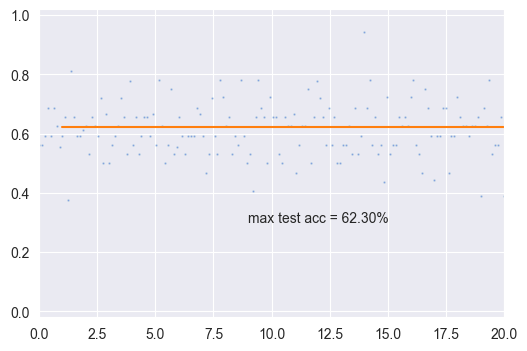

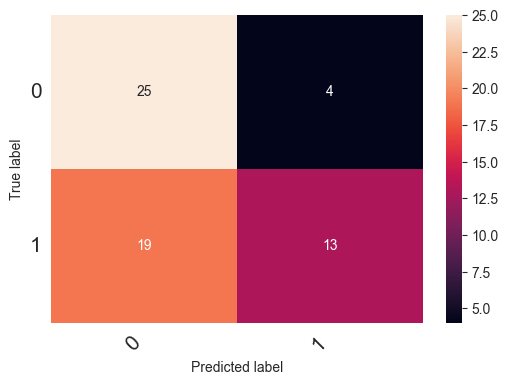

In [22]:
model = HeartModel(reverse=False).to(device)
print(f"Model has {count_parameters(model.parameters())} trainable parameters, "
      f"of which {count_parameters(viterbi_parameters(model))} are Viterbi "
      f"and {count_parameters(lukasiewicz_parameters(model))} are Lukasiewicz related")

viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.03106803054279518)
lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.08984594552823658)

train(
    model,
    heart_train_loader,
    heart_test_loader,
    [viterbi_optimiser, lukasiewicz_optimiser],
    [],
    nn.CrossEntropyLoss(),
    20,
)

Model has 1344 trainable parameters, of which 544 are Viterbi and 800 are Lukasiewicz related


''

  0%|          | 0/20 [00:00<?, ?it/s]

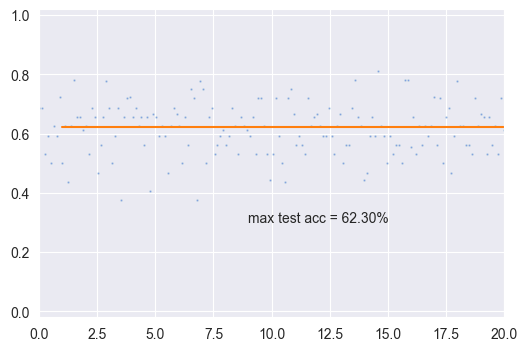

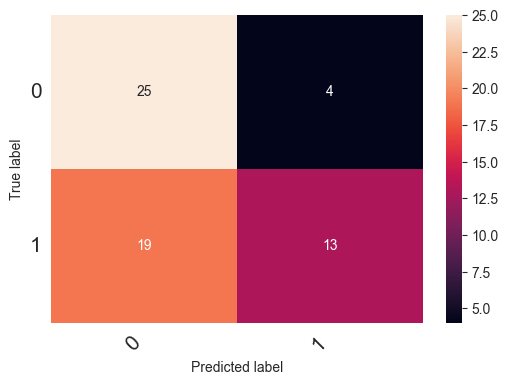

In [34]:
model = HeartModel(reverse=True).to(device)
print(f"Model has {count_parameters(model.parameters())} trainable parameters, "
      f"of which {count_parameters(viterbi_parameters(model))} are Viterbi "
      f"and {count_parameters(lukasiewicz_parameters(model))} are Lukasiewicz related")

viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.09170443419974666)
lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.0022586823725947633)
train(
    model,
    heart_train_loader,
    heart_test_loader,
    [viterbi_optimiser, lukasiewicz_optimiser],
    [],
    nn.CrossEntropyLoss(),
    20,
)

In [23]:
accs = []

for i in range(100):
    print(i)
    
    model = HeartModel(reverse=False).to(device)
    
    viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.03106803054279518)
    lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.08984594552823658)
    
    accs.append(train(
        model,
        heart_train_loader,
        heart_test_loader,
        [viterbi_optimiser, lukasiewicz_optimiser],
        [],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(accs))
print(quantiles(accs))
print(max(accs))

0.6229508196721312
[0.6229508196721312, 0.6229508196721312, 0.6229508196721312]
0.6229508196721312


In [35]:
accs = []

for i in range(100):
    print(i)

    model = HeartModel(reverse=True).to(device)
    
    viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.09170443419974666)
    lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.0022586823725947633)
    
    accs.append(train(
        model,
        heart_train_loader,
        heart_test_loader,
        [viterbi_optimiser, lukasiewicz_optimiser],
        [],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(accs))
print(quantiles(accs))
print(max(accs))

0.6229508196721312
[0.6229508196721312, 0.6229508196721312, 0.6229508196721312]
0.6229508196721312


# Circles

In [17]:
find_best_model_for(config={
    "dataset": "circles",
    "reverse": False,
})

Best trial config with accuracy of 0.6285266457680251: {'dataset': 'circles', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': True, 'viterbi_lr': 0.006838579252617862, 'lukasiewicz_lr': 0.005487104130213599}
-----------------
{'accuracy': 0.6285266457680251, 'config': {'dataset': 'circles', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': True, 'viterbi_lr': 0.006838579252617862, 'lukasiewicz_lr': 0.005487104130213599}}
{'accuracy': 0.6285266457680251, 'config': {'dataset': 'circles', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi_scheduler': True, 'lukasiewicz_optimiser': 'AdamW', 'lukasiewicz_scheduler': False, 'viterbi_lr': 0.002624766116490802, 'lukasiewicz_lr': 0.09836043973642494}}
{'accuracy': 0.6285266457680251, 'config': {'dataset': 'circles', 'reverse': False, 'viterbi_optimiser': 'AdamW', 'viterbi

In [15]:
find_best_model_for(config={
    "dataset": "circles",
    "reverse": True,
})

{'accuracy': 0.6137931034482759, 'config': {'dataset': 'circles', 'reverse': True, 'viterbi_lr': 0.007929146159086882, 'lukasiewicz_lr': 0.04381721668186534}}


Model has 256 trainable parameters, of which 112 are Viterbi and 144 are Lukasiewicz related


''

  0%|          | 0/20 [00:00<?, ?it/s]

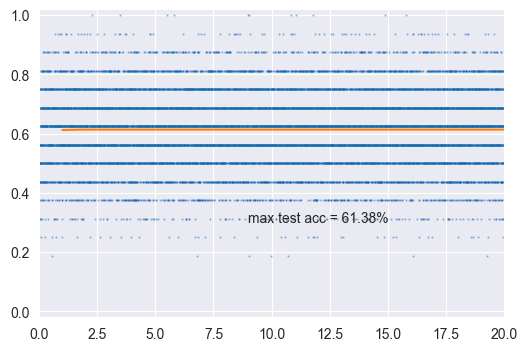

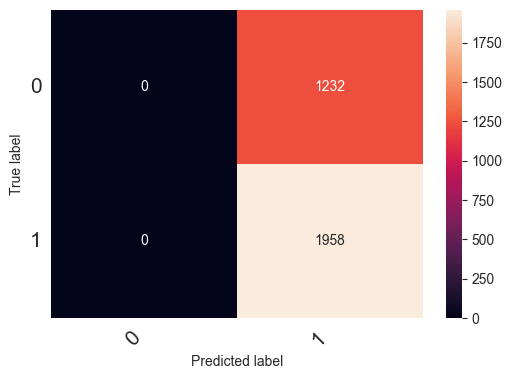

In [24]:
model = CirclesModel(reverse=False).to(device)
print(f"Model has {count_parameters(model.parameters())} trainable parameters, "
      f"of which {count_parameters(viterbi_parameters(model))} are Viterbi "
      f"and {count_parameters(lukasiewicz_parameters(model))} are Lukasiewicz related")

viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.002705404404523951)
lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.020324743705125672)

train(
    model,
    circles_train_loader,
    circles_test_loader,
    [viterbi_optimiser, lukasiewicz_optimiser],
    [],
    nn.CrossEntropyLoss(),
    20,
)

Model has 256 trainable parameters, of which 144 are Viterbi and 112 are Lukasiewicz related


''

  0%|          | 0/20 [00:00<?, ?it/s]

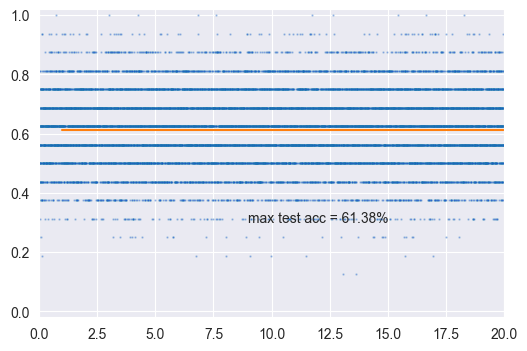

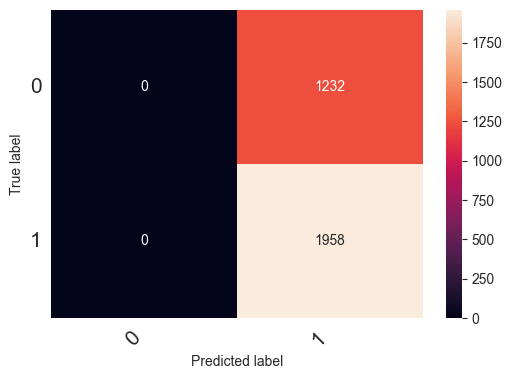

In [36]:
model = CirclesModel(reverse=True).to(device)
print(f"Model has {count_parameters(model.parameters())} trainable parameters, "
      f"of which {count_parameters(viterbi_parameters(model))} are Viterbi "
      f"and {count_parameters(lukasiewicz_parameters(model))} are Lukasiewicz related")

viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.007929146159086882)
lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.04381721668186534)
train(
    model,
    circles_train_loader,
    circles_test_loader,
    [viterbi_optimiser, lukasiewicz_optimiser],
    [],
    nn.CrossEntropyLoss(),
    20,
)

In [ ]:
accs = []

for i in range(100):
    print(i)
    
    model = CirclesModel(reverse=False).to(device)
    
    viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.002705404404523951)
    lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.020324743705125672)
    
    accs.append(train(
        model,
        circles_train_loader,
        circles_test_loader,
        [viterbi_optimiser, lukasiewicz_optimiser],
        [],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(accs))
print(quantiles(accs))
print(max(accs))

# accidentally deleted output:
# 0.6137931034482759
# [0.6137931034482759, 0.6137931034482759, 0.6137931034482759]
# 0.6137931034482759

In [37]:
accs = []

for i in range(100):
    print(i)
    
    model = CirclesModel(reverse=True).to(device)
    
    viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.007929146159086882)
    lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.04381721668186534)
    
    accs.append(train(
        model,
        circles_train_loader,
        circles_test_loader,
        [viterbi_optimiser, lukasiewicz_optimiser],
        [],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(accs))
print(quantiles(accs))
print(max(accs))

0.6137931034482759
[0.6137931034482759, 0.6137931034482759, 0.6137931034482759]
0.6137931034482759


# Rings

In [16]:
find_best_model_for(config={
    "dataset": "rings",
    "reverse": False,
})

{'accuracy': 0.5028888888888889, 'config': {'dataset': 'rings', 'reverse': False, 'viterbi_lr': 0.012816059381816637, 'lukasiewicz_lr': 0.003501989200603072}}


In [17]:
find_best_model_for(config={
    "dataset": "rings",
    "reverse": True,
})

{'accuracy': 0.5213333333333333, 'config': {'dataset': 'rings', 'reverse': True, 'viterbi_lr': 0.0017625634461251038, 'lukasiewicz_lr': 0.02249106924183407}}


Model has 264 trainable parameters, of which 120 are Viterbi and 144 are Lukasiewicz related


''

  0%|          | 0/20 [00:00<?, ?it/s]

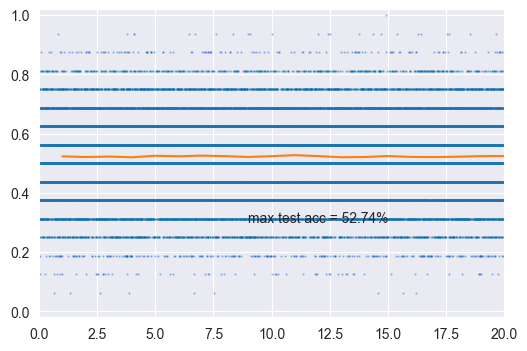

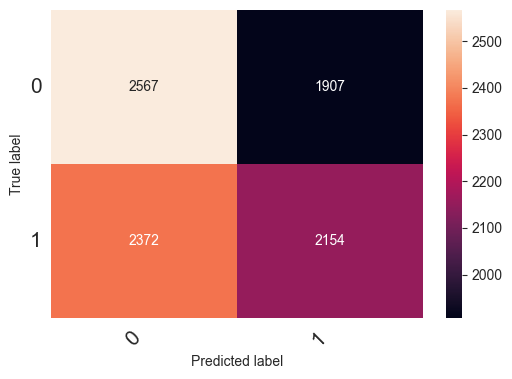

In [26]:
model = RingsModel(reverse=False).to(device)
print(f"Model has {count_parameters(model.parameters())} trainable parameters, "
      f"of which {count_parameters(viterbi_parameters(model))} are Viterbi "
      f"and {count_parameters(lukasiewicz_parameters(model))} are Lukasiewicz related")

viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.012816059381816637)
lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.003501989200603072)

train(
    model,
    rings_train_loader,
    rings_test_loader,
    [viterbi_optimiser, lukasiewicz_optimiser],
    [],
    nn.CrossEntropyLoss(),
    20,
)

Model has 264 trainable parameters, of which 144 are Viterbi and 120 are Lukasiewicz related


''

  0%|          | 0/20 [00:00<?, ?it/s]

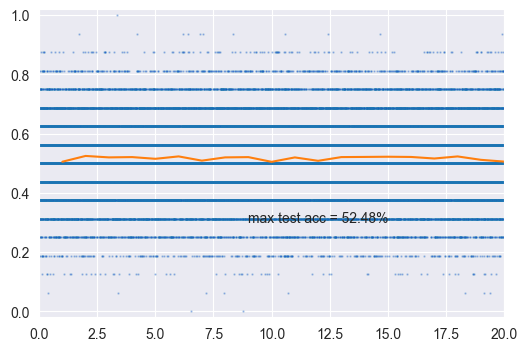

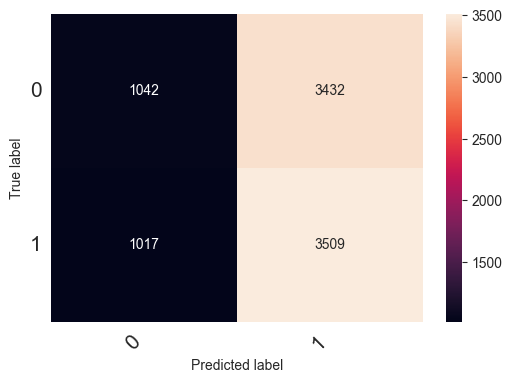

In [38]:
model = RingsModel(reverse=True).to(device)
print(f"Model has {count_parameters(model.parameters())} trainable parameters, "
      f"of which {count_parameters(viterbi_parameters(model))} are Viterbi "
      f"and {count_parameters(lukasiewicz_parameters(model))} are Lukasiewicz related")

viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.0017625634461251038)
lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.02249106924183407)
train(
    model,
    rings_train_loader,
    rings_test_loader,
    [viterbi_optimiser, lukasiewicz_optimiser],
    [],
    nn.CrossEntropyLoss(),
    20,
)

In [27]:
accs = []

for i in range(100):
    print(i)
    
    model = RingsModel(reverse=False).to(device)
    
    viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.012816059381816637)
    lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.003501989200603072)
    
    accs.append(train(
        model,
        rings_train_loader,
        rings_test_loader,
        [viterbi_optimiser, lukasiewicz_optimiser],
        [],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(accs))
print(quantiles(accs))
print(max(accs))

0.5245555555555556
[0.5273333333333333, 0.5277777777777778, 0.5284444444444445]
0.5291111111111111


In [14]:
accs = []

for i in range(100):
    print(i)
    
    model = RingsModel(reverse=True).to(device)
    
    viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.0017625634461251038)
    lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.02249106924183407)
    
    accs.append(train(
        model,
        rings_train_loader,
        rings_test_loader,
        [viterbi_optimiser, lukasiewicz_optimiser],
        [],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(accs))
print(quantiles(accs))
print(max(accs))

0.5191111111111111
[0.5207777777777778, 0.5214444444444445, 0.5223333333333333]
0.5532222222222222


# Spheres

In [18]:
find_best_model_for(config={
    "dataset": "spheres",
    "reverse": False,
})

{'accuracy': 0.5236772486772486, 'config': {'dataset': 'spheres', 'reverse': False, 'viterbi_lr': 0.015743678679270515, 'lukasiewicz_lr': 0.009756148217878345}}


In [19]:
find_best_model_for(config={
    "dataset": "spheres",
    "reverse": True,
})

{'accuracy': 0.5236772486772486, 'config': {'dataset': 'spheres', 'reverse': True, 'viterbi_lr': 0.0027498664113907033, 'lukasiewicz_lr': 0.003584292769519744}}


Model has 264 trainable parameters, of which 120 are Viterbi and 144 are Lukasiewicz related


''

  0%|          | 0/20 [00:00<?, ?it/s]

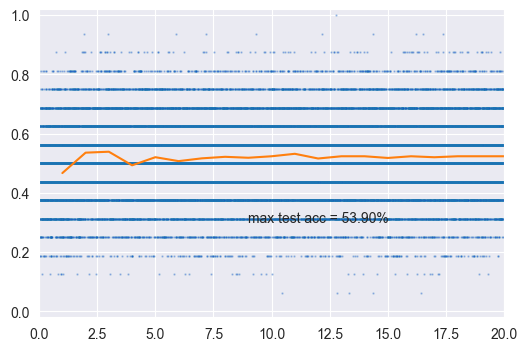

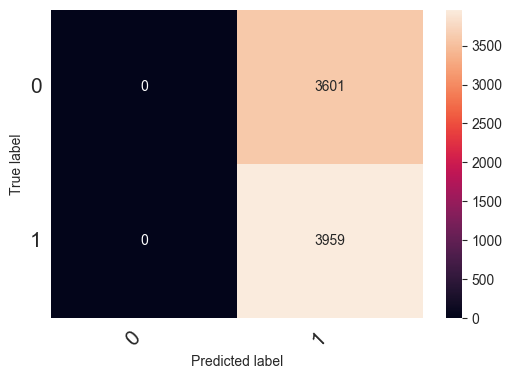

In [28]:
model = SpheresModel(reverse=False).to(device)
print(f"Model has {count_parameters(model.parameters())} trainable parameters, "
      f"of which {count_parameters(viterbi_parameters(model))} are Viterbi "
      f"and {count_parameters(lukasiewicz_parameters(model))} are Lukasiewicz related")

viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.015743678679270515)
lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.009756148217878345)

train(
    model,
    spheres_train_loader,
    spheres_test_loader,
    [viterbi_optimiser, lukasiewicz_optimiser],
    [],
    nn.CrossEntropyLoss(),
    20,
)

Model has 264 trainable parameters, of which 144 are Viterbi and 120 are Lukasiewicz related


''

  0%|          | 0/20 [00:00<?, ?it/s]

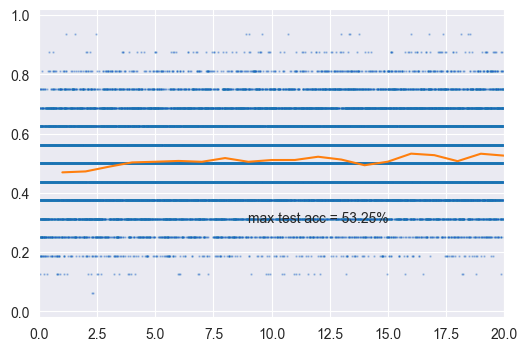

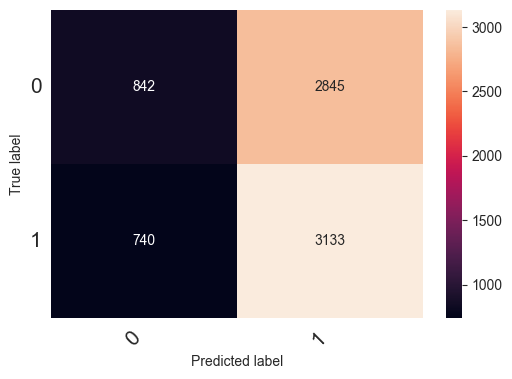

In [15]:
model = SpheresModel(reverse=True).to(device)
print(f"Model has {count_parameters(model.parameters())} trainable parameters, "
      f"of which {count_parameters(viterbi_parameters(model))} are Viterbi "
      f"and {count_parameters(lukasiewicz_parameters(model))} are Lukasiewicz related")

viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.0027498664113907033)
lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.003584292769519744)

train(
    model,
    spheres_train_loader,
    spheres_test_loader,
    [viterbi_optimiser, lukasiewicz_optimiser],
    [],
    nn.CrossEntropyLoss(),
    20,
)

In [29]:
accs = []

for i in range(100):
    print(i)
    
    model = SpheresModel(reverse=False).to(device)
    
    viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.015743678679270515)
    lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.009756148217878345)

    accs.append(train(
        model,
        spheres_train_loader,
        spheres_test_loader,
        [viterbi_optimiser, lukasiewicz_optimiser],
        [],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(accs))
print(quantiles(accs))
print(max(accs))

0.5236772486772486
[0.5338624338624338, 0.5384920634920635, 0.5402116402116403]
0.5416666666666666


In [16]:
accs = []

for i in range(100):
    print(i)
    
    model = SpheresModel(reverse=True).to(device)
    
    viterbi_optimiser = ClampSGD(viterbi_parameters(model), lr=0.0027498664113907033)
    lukasiewicz_optimiser = ClampSGD(lukasiewicz_parameters(model), lr=0.003584292769519744)

    accs.append(train(
        model,
        spheres_train_loader,
        spheres_test_loader,
        [viterbi_optimiser, lukasiewicz_optimiser],
        [],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(accs))
print(quantiles(accs))
print(max(accs))

0.5208994708994709
[0.5297619047619048, 0.5317460317460317, 0.5326719576719576]
0.5332010582010582
